# Photovoltaics Interactive Tabletop Supporting Code

`Cristian Sorescu 879091`


Human activity recognition in indoor environments is useful for comfortable and efficient living and working in smart homes and buildings. Energy harvesting technologies such as the photovoltaics could offer advantages for low-cost installation and maintenance, portability and energy savings. We explore large area indoor photovoltaic (PV) sheets for both energy harvesting and gesture recognition.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, itertools, pywt, scipy, eli5
from eli5.sklearn import PermutationImportance
from collections import Counter
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone 

# CNN
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Flatten, Dropout, Convolution1D, AveragePooling1D, concatenate

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# KNN
from sklearn.neighbors import KNeighborsClassifier

# SVM 
from sklearn.svm import SVC


/Users/cristian/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/cristian/.pyenv/versions/3.6.8/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


## Helper Functions

In [2]:
'''
Extract filename from a given path.

Input: 
    _path - given path from which name has to be extracted
    
Output:
    extracted file name
            
'''
def path_to_fname(_path):
    return os.path.basename(os.path.splitext(_path)[0])

'''
Remove digits and underscore _ from a given string.

Input: 
    _string - string to be processed 
    
Output:
    resulting string without digits and _
            
'''
def rm_digit_undscore(_string):
    return _string.split("_", 1)[0]


'''
Load data from a given file list.

Input: 
    file_list - list of files 
    
Output:
    classes - class names for each loaded file
    gestures - gestures photocurrent (V) values 
            
'''
def load_data(file_list):
    classes = []
    gestures = []
    
    for fp in file_list:
        gesture = pd.read_csv(fp, delim_whitespace=False, header=[0, 1], index_col=0)
        gesture = gesture.rolling(window = 100).mean()
        gesture = gesture.dropna()
        gestures.append(gesture.values)
        classes.append(rm_digit_undscore(path_to_fname(fp)))
    
    gestures = np.array(gestures)
    classes = np.array(classes)
    return classes, gestures

# Lag Features generation, 
# predict the value at the next time (t+1) given the value at the previous time (t-1).
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data
    cols, names = list(), list()
    # input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

# definition of cnn model
def get_model(_shape, num_classes):
    # number of classes
    #nclass = 6
    
    inp = Input(shape=_shape)
    print(inp)
    
    model = models.Sequential()
    
    # layers
    # kernel size as tuple
    model.add(Convolution1D(6, kernel_size=7, activation=activations.relu, input_shape=_shape,\
                            padding="valid"))
    #model.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid"))
    model.add(AveragePooling1D(pool_size=3))
    #model.add(Dropout(rate=0.1))
    model.add(Convolution1D(12, kernel_size=7, activation=activations.relu, padding="valid"))
    #model.add(Convolution1D(4, kernel_size=3, activation=activations.relu, padding="valid"))
    model.add(AveragePooling1D(pool_size=3))
    #model.add(Dropout(rate=0.1))
#     model.add(Convolution1D(4, kernel_size=3, activation=activations.relu, padding="valid"))
#     model.add(Convolution1D(4, kernel_size=3, activation=activations.relu, padding="valid"))
#     model.add(MaxPool1D(pool_size=2))
#     model.add(Dropout(rate=0.1))
#     model.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
#     #model.add(Convolution1D(128, kernel_size=3, activation=activations.relu, padding="valid"))
    #model.add(GlobalMaxPool1D())
    model.add(Flatten())
    #model.add(Dropout(rate=0.2))

    model.add(Dense(64, activation=activations.relu, name="dense_1"))
    #model.add(Dense(64, activation=activations.relu, name="dense_2"))
    model.add(Dense(num_classes, activation=activations.softmax, name="output"))

    # model definition
    #model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy,\
                  metrics=['accuracy'])
    model.summary()
    
    return model

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def lowpassfilter(data, thresh = 0.63, waveletname = "db4"):
    thresh = thresh*np.nanmax(data)
    coeff = pywt.wavedec(data, waveletname, mode="per")
    coeff[1:] = (pywt.threshold(i, value=thresh, mode="soft" ) for i in coeff[1:])
    reconstructed_signal = pywt.waverec(coeff, waveletname, mode="per")
    
    return reconstructed_signal

# apply low-pass filter on given data 
def apply_lowpassfilter(dataset, waveletname = "db4"):
    data_lowpassfilter = []
    dataset = dataset.reshape(dataset.shape[0], dataset.shape[2])

    batch_size = dataset.shape[0]
    for i in range(batch_size):
        data_lowpassfilter.append(lowpassfilter(dataset[i, :], 0.4, waveletname))
    
    data_lowpassfilter = np.array(data_lowpassfilter)
    data_lowpassfilter = np.expand_dims(data_lowpassfilter, axis=[1,-1])
    return data_lowpassfilter

'''
    Below are function extracting features which are most frequently used for time series signals.

    Auto-regressive model coefficient values
    
    Entropy values - entropy values can be taken as a measure of complexity of the signal
    
    Statistical features like:
        variance
        standard deviation
        Mean
        Median
        25th percentile value
        75th percentile value
        Root Mean Square value; 
        square of the average of the squared amplitude values
        The mean of the derivative
        Zero crossing rate, i.e. the number of times a signal crosses y = 0
        Mean crossing rate, i.e. the number of times a signal crosses y = mean(y)
'''
# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def calculate_entropy(list_values):
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1] / len(list_values) for elem in counter_values]
    entropy = scipy.stats.entropy(probabilities)
    return [entropy]

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def calculate_statistics(list_values):
    n25 = np.nanpercentile(list_values, 25)
    median = np.nanpercentile(list_values, 50)
    mean = np.nanmean(list_values)
    variab = np.nanvar(list_values)
    rms = np.nanmean(np.sqrt(list_values**2))
    max_v = max(list_values)
    
    #return [n25, median, mean, variab, rms, max_v]

    # more features
    n5 = np.nanpercentile(list_values, 5)
    n75 = np.nanpercentile(list_values, 75)
    n95 = np.nanpercentile(list_values, 95)
    std = np.nanstd(list_values)
    min_v = min(list_values) 
    return [n5, n25, n75, n95, median, mean, std, variab, rms, min_v, max_v, max_v - min_v]

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def calculate_crossings(list_values):
    mean_crossing_indices = np.nonzero(np.diff(np.array(list_values) > np.nanmean(list_values)))[0]
    no_mean_crossings = len(mean_crossing_indices)
    #return [no_mean_crossings]
    
    # more features
    zero_crossing_indices = np.nonzero(np.diff(np.array(list_values) > 0))[0]
    no_zero_crossings = len(zero_crossing_indices)
    return [no_zero_crossings, no_mean_crossings]

# source: http://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/
def get_features(list_values):
    crossings = calculate_crossings(list_values)
    statistics = calculate_statistics(list_values)
    #return crossings + statistics

    # more features
    entropy = calculate_entropy(list_values)
    return entropy + crossings + statistics

'''
Extract features for each gesture in the given dataset.

Input: 
    dataset - dataset containing the gestures signals
    labels - gestures labels for elements in the given 'dataset'
    waveletname - name of wavelet for dwt
    
Output:
    data - extracted features vectors 
    classes - classes identifying each feature vector in 'data'
            
'''
def get_gestures_features(dataset, labels, waveletname):
    all_features = []
    for data in dataset[:, 0, :, 0]:
        features = []
        list_coeff = pywt.wavedec(data, waveletname)
#         for coeff in list_coeff:
#             features += get_features(coeff)
        features = get_features(data)
        all_features.append(features)
    
    data = np.array(all_features)
    data = np.expand_dims(data, axis=[1,-1])
    classes = np.array(labels)
    
    return data, classes

# Confusion matrix plot function definition
# source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.tight_layout()
    
def load_pc_data(file_list):
    classes = []
    gestures = []
    
    for fp in file_list:
        gesture = pd.read_csv(fp, delim_whitespace=False)
#         gesture = gesture.rolling(window = 100).mean()
#         gesture = gesture.dropna()
        gestures.append(gesture.values)
        classes.append(rm_digit_undscore(path_to_fname(fp)))
    
    gestures = np.array(gestures)
    classes = np.array(classes)
    return classes, gestures
    

## Load Gestures Data and Classes

In [3]:
path = "csv/data/*/"
gestures_files = glob.glob(path + '/*.csv')
classes, data = load_data(gestures_files)

data = np.expand_dims(data, axis=1)
print(data.shape)

(154, 1, 14905, 1)


## Load Photocurrent Data

This data does not contain the temporal domain.

In [844]:
# photocurrent test data without timporal domain
paths = ["csv/filter_50Hz/trainc/*/", "csv/filter_50Hz/testc/"]

gestures_files = glob.glob(paths[0] + '*.csv')
classes_0, data_0 = load_pc_data(gestures_files)

gestures_files = glob.glob(paths[1] + '*.csv')
classes_1, data_1 = load_pc_data(gestures_files)

data = np.concatenate((data_0, data_1))
data = np.expand_dims(data, axis=1)

classes = np.concatenate((classes_0, classes_1))

In [845]:
print('data shape:', data.shape, 'classes shape: ', classes.shape)

data shape: (160, 1, 14988, 1) classes shape:  (160,)


## CNN

input layer parameters (batchSize, length, channels).

batchSize = number of gesture files (optional)    
length = number of lines in each file   
?? channels = dimension of the embedding's output (calsses)  

### Split Gestures Data Into Train/Test Sets

In [4]:
train_data, test_data,\
train_classes, test_classes = train_test_split(data, classes, test_size=0.22, random_state=42, stratify=classes)

print("Train samples: {0}, Test samples: {1}".format(train_data.shape[0], test_data.shape[0]))

Train samples: 120, Test samples: 34


## Encode Class Labels

In [5]:
# encode labels
label_encoder = preprocessing.LabelEncoder()
enc_train_labels = label_encoder.fit_transform(train_classes)

print("*Encoded labels*\n")
for (enc, name) in zip(np.unique(enc_train_labels), np.unique(train_classes)):
    print("Gesture class: {0}, Label: {1}".format(name, enc))

*Encoded labels*

Gesture class: clockwise, Label: 0
Gesture class: counterclockwise, Label: 1
Gesture class: fistForm, Label: 2
Gesture class: raiseLower, Label: 3
Gesture class: swipe, Label: 4
Gesture class: swipes, Label: 5


In [7]:
num_classes = len(np.unique(train_classes))
cnn_model = get_model(train_data[0, 0, :].shape, num_classes)

Tensor("input_1:0", shape=(None, 14905, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14899, 6)          48        
_________________________________________________________________
average_pooling1d_1 (Average (None, 4966, 6)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4960, 12)          516       
_________________________________________________________________
average_pooling1d_2 (Average (None, 1653, 12)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19836)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1269568   
_____________________________________________________________

In [8]:
# checkpoint = ModelCheckpoint('cnn_best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# fit data into the cnn model, training
history = cnn_model.fit(train_data[:,0,:], enc_train_labels, epochs=100, verbose=1)

Epoch 1/100
120/120 [==============================] - 1s 11ms/step - loss: 1.7591 - accuracy: 0.3000
Epoch 2/100
120/120 [==============================] - 1s 8ms/step - loss: 1.5170 - accuracy: 0.5083
Epoch 3/100
120/120 [==============================] - 1s 8ms/step - loss: 1.1532 - accuracy: 0.5833
Epoch 4/100
120/120 [==============================] - 1s 6ms/step - loss: 0.8250 - accuracy: 0.7667
Epoch 5/100
120/120 [==============================] - 1s 10ms/step - loss: 0.5945 - accuracy: 0.8250
Epoch 6/100
120/120 [==============================] - 1s 8ms/step - loss: 0.4710 - accuracy: 0.8500
Epoch 7/100
120/120 [==============================] - 1s 6ms/step - loss: 0.3477 - accuracy: 0.8833
Epoch 8/100
120/120 [==============================] - 1s 9ms/step - loss: 0.2708 - accuracy: 0.9167
Epoch 9/100
120/120 [==============================] - 1s 9ms/step - loss: 0.1949 - accuracy: 0.9417
Epoch 10/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1524 - accu

120/120 [==============================] - 1s 7ms/step - loss: 4.8795e-04 - accuracy: 1.0000
Epoch 81/100
120/120 [==============================] - 1s 6ms/step - loss: 4.7812e-04 - accuracy: 1.0000
Epoch 82/100
120/120 [==============================] - 1s 5ms/step - loss: 4.6665e-04 - accuracy: 1.0000
Epoch 83/100
120/120 [==============================] - 1s 5ms/step - loss: 4.5491e-04 - accuracy: 1.0000
Epoch 84/100
120/120 [==============================] - 1s 5ms/step - loss: 4.4333e-04 - accuracy: 1.0000
Epoch 85/100
120/120 [==============================] - 1s 5ms/step - loss: 4.3458e-04 - accuracy: 1.0000
Epoch 86/100
120/120 [==============================] - 1s 5ms/step - loss: 4.2295e-04 - accuracy: 1.0000
Epoch 87/100
120/120 [==============================] - 1s 6ms/step - loss: 4.1437e-04 - accuracy: 1.0000
Epoch 88/100
120/120 [==============================] - 2s 13ms/step - loss: 4.0648e-04 - accuracy: 1.0000
Epoch 89/100
120/120 [==============================] - 2s

In [9]:
cnn_pred = cnn_model.predict(test_data[:,0,:,:])
cnn_pred = np.argmax(cnn_pred, axis=-1)
cnn_pred = label_encoder.inverse_transform(cnn_pred)

correct_preds = np.nonzero(cnn_pred == test_classes)[0]
incorrect_preds = np.nonzero(cnn_pred != test_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_classes, cnn_pred, average="macro")
print("\nTest f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_classes, cnn_pred)
print("Test accuracy score : %s"% acc)

26 classified correctly
8 classified incorrectly

Test f1 score : 0.7691382691382692 
Test accuracy score : 0.7647058823529411


### CNN Confusion matrix

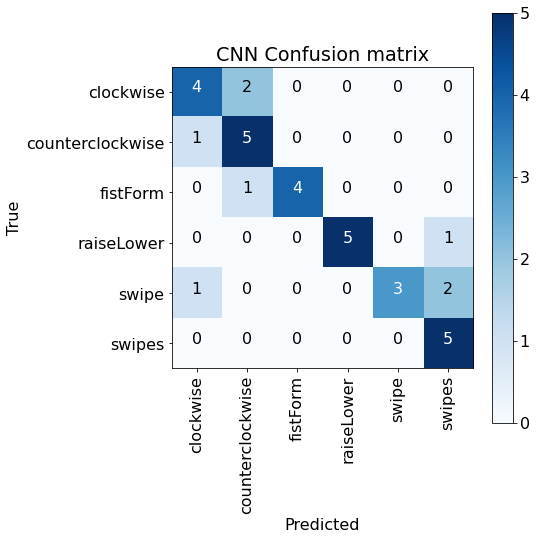

In [10]:
# compute confusion matrix
cnn_matrix = confusion_matrix(test_classes, cnn_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnn_matrix, np.unique(test_classes), title='CNN Confusion matrix')

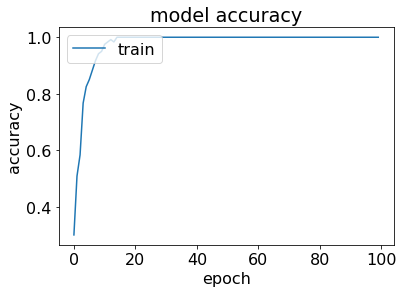

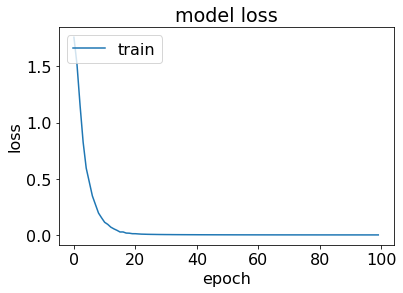

In [11]:
# summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.figure()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Extract Features
Extract features from the getures datasets (train and test)

In [12]:
# train features
data_features, features_classes = get_gestures_features(data, classes, 'db1')
print('Extracted train features shape: {0}'.format(data_features.shape))

Extracted train features shape: (154, 1, 15, 1)


In [13]:
# train features

# 15 features
features_names = ['entropy', 'zero crossings', 'mean crossings', '5th percentile', '25th percentile',\
                  '75th percentile', '95th percentile', 'median', 'mean', 'standard deviation', 'variability',\
                  'root mean square', 'min', 'max', 'range']

# 7 features
# features_names = ['mean crossings', '25th percentile', 'median', 'mean', 'variability', 'root mean square',\
#                   'max']

features_dt = pd.DataFrame(data_features[:,0,:,0], columns=features_names)
clases_dt = pd.DataFrame(features_classes, columns=['gesture'])
features_dt = pd.concat([features_dt, clases_dt], axis=1)
features_dt

,entropy,zero crossings,mean crossings,5th percentile,25th percentile,75th percentile,95th percentile,median,mean,standard deviation,variability,root mean square,min,max,range,gesture
0,9.609266,81.0,96.0,-0.092136,-0.028523,0.057738,0.158189,0.000596,0.014435,0.074983,0.005623,0.057031,-0.120238,0.194704,0.314942,raiseLower
1,9.609266,97.0,20.0,-0.088135,-0.034453,0.074136,0.185902,-0.000496,0.021405,0.081993,0.006723,0.062354,-0.115624,0.230321,0.345944,raiseLower
2,9.608708,103.0,29.0,-0.119365,-0.053371,0.063665,0.179602,-0.009353,0.008363,0.089863,0.008075,0.069384,-0.146800,0.232782,0.379582,raiseLower
3,9.608894,17.0,138.0,-0.073114,-0.033194,0.025138,0.153477,-0.008762,0.010175,0.065932,0.004347,0.048970,-0.100093,0.182484,0.282576,raiseLower
4,9.608894,47.0,95.0,-0.096912,-0.054587,0.071350,0.178771,-0.008507,0.013161,0.088688,0.007866,0.069235,-0.137920,0.235660,0.373581,raiseLower
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,9.608801,8.0,6.0,-0.284187,0.024446,0.095693,0.170059,0.060750,0.013966,0.140863,0.019842,0.116341,-0.368744,0.191928,0.560671,counterclockwise
150,9.609080,116.0,22.0,-0.317859,-0.041108,0.073554,0.117305,0.019785,-0.015442,0.130092,0.016924,0.091667,-0.422473,0.132605,0.555077,counterclockwise
151,9.609080,6.0,83.0,-0.158619,0.021417,0.078359,0.104927,0.054150,0.027435,0.085064,0.007236,0.074610,-0.315975,0.140984,0.456959,counterclockwise
152,9.609173,6.0,25.0,-0.343290,0.020805,0.117952,0.162551,0.062288,0.015850,0.155547,0.024195,0.126046,-0.425235,0.178228,0.603463,counterclockwise


### Split Gestures Data Into Train/Test Sets

In [14]:
train_features, test_features,\
train_ft_classes, test_ft_classes = train_test_split(data_features, features_classes, test_size=0.22,\
                                                     random_state=42, stratify=features_classes)

print("Train samples: {0}, Test samples: {1}".format(train_features.shape[0], test_features.shape[0]))

Train samples: 120, Test samples: 34


## KNN
Classifier implementing the k-nearest neighbours vote.

In [138]:
knn_model = KNeighborsClassifier(n_neighbors=22, weights='distance')

In [139]:
knn_model.fit(train_features[:,0,:,0], train_ft_classes)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=22, p=2,
                     weights='distance')

In [140]:
# apply knn model on test data
knn_pred = knn_model.predict(test_features[:,0,:,0])

correct_preds = np.nonzero(knn_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(knn_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

# compute accuracy of the knn model
knn_train_score = knn_model.score(train_features[:,0,:,0], train_ft_classes)
print("Accuracy on the train dataset: ", knn_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, knn_pred, average="macro")
print("Test f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, knn_pred)
print("Accuracy on the test dataset: %s"% acc)


21 classified correctly
13 classified incorrectly
Accuracy on the train dataset:  1.0
Test f1 score : 0.6295454545454545 
Accuracy on the test dataset: 0.6176470588235294


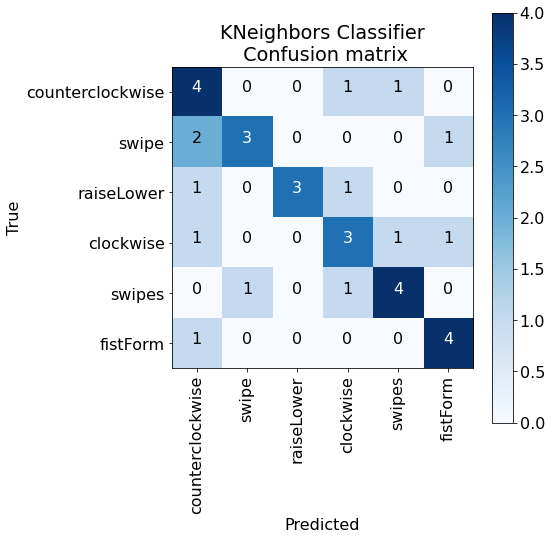

In [141]:
# compute confusion matrix
knn_matrix = confusion_matrix(test_ft_classes, knn_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(knn_matrix, set(test_classes), title='KNeighbors Classifier\n Confusion matrix')

## Random Forest

In [19]:
# random forest model
parameters = {'bootstrap': True,
              'n_estimators': 70, 
              'min_samples_split': 6,
              'min_samples_leaf' : 1,
              'max_depth': 6,
              'oob_score': True,
              'random_state': 42,
              'max_features': 0.23}

rf_model = RandomForestClassifier(**parameters)

In [20]:
# fit/train random forest model
rf_model.fit(train_features[:,0,:,0], train_ft_classes)
#print('train data shape: ', train_features.shape)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=0.23,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [21]:
# apply random forest model on test data
#print('test data shape: ', test_features.shape)
rf_pred = rf_model.predict(test_features[:,0,:,0])

correct_preds = np.nonzero(rf_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(rf_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

rf_train_score = rf_model.score(train_features[:,0,:,0], train_ft_classes)
print("Accuracy on the train dataset (R^2 Training Score): ", rf_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, rf_pred, average="macro")
print("Test f1 score : %s "% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, rf_pred)
print("Accuracy on the test dataset: %s"% acc)

print('OOB Score: {} \nR^2 Validation Score: {}'
      .format(rf_model.oob_score_, rf_model.score(test_features[:,0,:,0], test_ft_classes)))


31 classified correctly
3 classified incorrectly
Accuracy on the train dataset (R^2 Training Score):  0.9666666666666667
Test f1 score : 0.9160839160839161 
Accuracy on the test dataset: 0.9117647058823529
OOB Score: 0.7916666666666666 
R^2 Validation Score: 0.9117647058823529


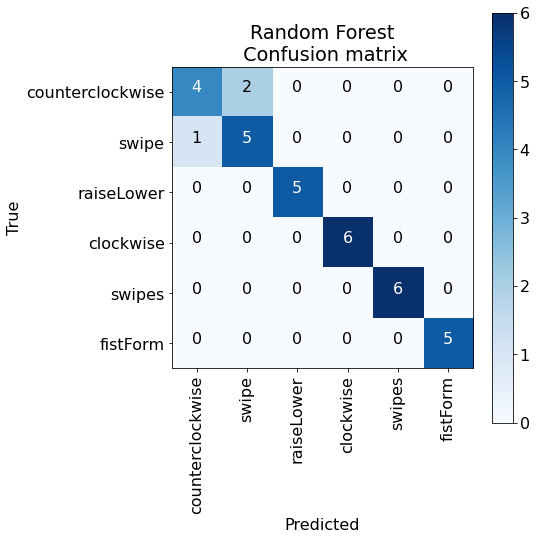

In [22]:
# compute confusion matrix
rf_matrix = confusion_matrix(test_ft_classes, rf_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(rf_matrix, set(test_ft_classes), title='Random Forest\n Confusion matrix')

### Feature Importance

Feature ranking:
1. min (0.175625)
2. range (0.141519)
3. 5th percentile (0.126359)
4. standard deviation (0.108239)
5. variability (0.101374)
6. 95th percentile (0.074148)
7. root mean square (0.065964)
8. max (0.049592)
9. median (0.048150)
10. 25th percentile (0.039403)
11. mean crossings (0.020646)
12. 75th percentile (0.017302)
13. mean (0.013632)
14. zero crossings (0.010950)
15. entropy (0.007095)


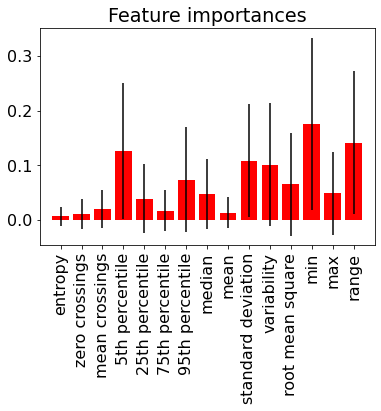

In [23]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_features[:,0,:,0].shape[1]):
    print("%d. %s (%f)" % (f + 1, features_names[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train_features[:,0,:,0].shape[1]), importances,
        color="r", yerr=std, align="center")
plt.xticks(range(train_features[:,0,:,0].shape[1]), features_names, rotation=90)
plt.xlim([-1, train_features[:,0,:,0].shape[1]])
plt.show()

Permutation Feature ranking:
1. min (0.021000)
2. median (0.014333)
3. range (0.010833)
4. 25th percentile (0.009000)
5. mean crossings (0.007500)
6. max (0.005667)
7. zero crossings (0.002667)
8. 5th percentile (0.002500)
9. 75th percentile (0.002500)
10. mean (0.002333)
11. entropy (0.000000)
12. standard deviation (-0.000667)
13. 95th percentile (-0.001833)
14. variability (-0.002500)
15. root mean square (-0.003167)


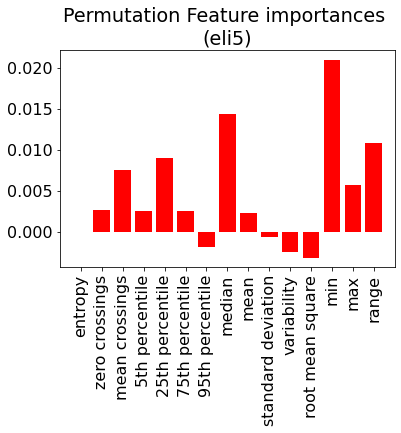

In [24]:
perm = PermutationImportance(rf_model, cv = None, refit = False, n_iter = 50)\
       .fit(train_features[:,0,:,0], train_ft_classes)

# Print the feature ranking
print("Permutation Feature ranking:")

indices = np.argsort(perm.feature_importances_)[::-1]

for f in range(train_features[:,0,:,0].shape[1]):
    print("%d. %s (%f)" % (f + 1, features_names[indices[f]], perm.feature_importances_[indices[f]]))

# Plot the premutation-based feature importances of the forest
plt.figure()
plt.title("Permutation Feature importances \n(eli5)")
plt.bar(range(train_features[:,0,:,0].shape[1]), perm.feature_importances_,
        color="r", align="center")
plt.xticks(range(train_features[:,0,:,0].shape[1]), features_names, rotation=90)
plt.xlim([-1, train_features[:,0,:,0].shape[1]])
plt.show()

In [25]:
# feature importance per class
def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(X_train, y_train)
    benchmark_score = model_clone.score(X_train, y_train)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in range(X_train.shape[1]):
        model_clone = clone(model)
        model_clone.random_state = random_state
        
        tmp_train = np.delete(X_train, col, axis=1)
        
        model_clone.fit(tmp_train, y_train)
        drop_col_score = model_clone.score(tmp_train, y_train)
        importances.append(benchmark_score - drop_col_score)
    
    return np.asarray(importances)

Drop 1 Column Feature ranking:
1. min (0.019481)
2. root mean square (0.012987)
3. mean (0.006494)
4. 25th percentile (0.006494)
5. max (0.000000)
6. 75th percentile (0.000000)
7. 5th percentile (0.000000)
8. mean crossings (0.000000)
9. range (-0.006494)
10. median (-0.006494)
11. 95th percentile (-0.006494)
12. zero crossings (-0.006494)
13. entropy (-0.006494)
14. variability (-0.012987)
15. standard deviation (-0.012987)


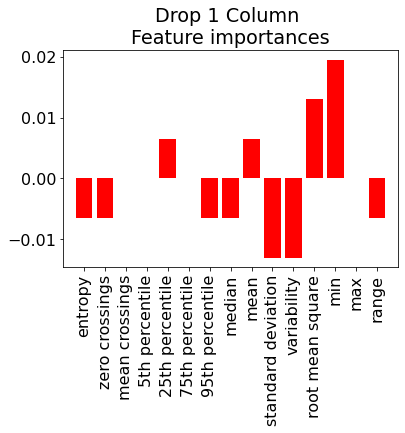

In [26]:
drop_col_importances = drop_col_feat_imp(rf_model, data_features[:,0,:,0], features_classes)

# Print the feature ranking
print("Drop 1 Column Feature ranking:")

indices = np.argsort(drop_col_importances)[::-1]

for f in range(train_features[:,0,:,0].shape[1]):
    print("%d. %s (%f)" % (f + 1, features_names[indices[f]], drop_col_importances[indices[f]]))

# Plot the drop 1 column feature importances of the forest
plt.figure()
plt.title("Drop 1 Column \nFeature importances")
plt.bar(range(train_features[:,0,:,0].shape[1]), drop_col_importances,
        color="r", align="center")
plt.xticks(range(train_features[:,0,:,0].shape[1]), features_names, rotation=90)
plt.xlim([-1, train_features[:,0,:,0].shape[1]])
plt.show()

## Gradient Boosting Classifier

In [27]:
# Gradient Boosting Classifier (GBC) model
parameters = {'n_estimators': 100, 'max_depth': 3}
gbc_model = GradientBoostingClassifier(**parameters)

In [28]:
# fit/train GBC model
gbc_model.fit(train_features[:,0,:,0], train_ft_classes)
#print('train data shape: ', train_features.shape)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [29]:
# apply GBC model on test data
#print('test data shape: ', test_features.shape)
gbc_pred = gbc_model.predict(test_features[:,0,:,0])

correct_preds = np.nonzero(gbc_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(gbc_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

# compute accuracy of the GBC model
gbc_train_score = gbc_model.score(train_features[:,0,:,0], train_ft_classes)
print("Accuracy on the train dataset: ", gbc_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, gbc_pred, average="macro")
print("Test f1 score: %s"% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, gbc_pred)
print("Accuracy on the test dataset: %s"% acc)

31 classified correctly
3 classified incorrectly
Accuracy on the train dataset:  1.0
Test f1 score: 0.9078144078144078
Accuracy on the test dataset: 0.9117647058823529


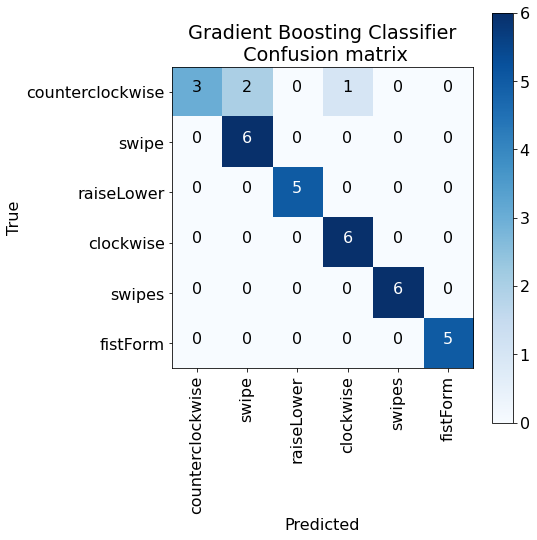

In [30]:
# compute confusion matrix
gbc_matrix = confusion_matrix(test_ft_classes, gbc_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(gbc_matrix, set(test_ft_classes), title='Gradient Boosting Classifier\n Confusion matrix')

## C-Support Vector Classification SVC

In [31]:
# SVC model
svc_model = SVC(kernel='linear', gamma='scale')

In [32]:
# Fit train data
svc_model.fit(train_features[:, 0, :, 0], train_ft_classes)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [33]:
# apply SVC model on test data
svc_pred = svc_model.predict(test_features[:, 0, :, 0])

correct_preds = np.nonzero(svc_pred == test_ft_classes)[0]
incorrect_preds = np.nonzero(svc_pred != test_ft_classes)[0]

print("{0} classified correctly".format(len(correct_preds)))
print("{0} classified incorrectly".format(len(incorrect_preds)))

# compute accuracy of the GBC model
svc_train_score = svc_model.score(train_features[:, 0, :, 0], train_ft_classes)
print("Accuracy on the train dataset: ", svc_train_score)

# f1 score, weighted average of the precision and recall, 
# f1 score reaches its best value at 1 and worst score at 0.
f1 = f1_score(test_ft_classes, svc_pred, average="macro")
print("Test f1 score: %s"% f1)

# accuracy score, set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
# accuracy score reaches its best value at 1 and worst score at 0.
acc = accuracy_score(test_ft_classes, svc_pred)
print("Accuracy on the test dataset: %s"% acc)

20 classified correctly
14 classified incorrectly
Accuracy on the train dataset:  0.725
Test f1 score: 0.598941798941799
Accuracy on the test dataset: 0.5882352941176471


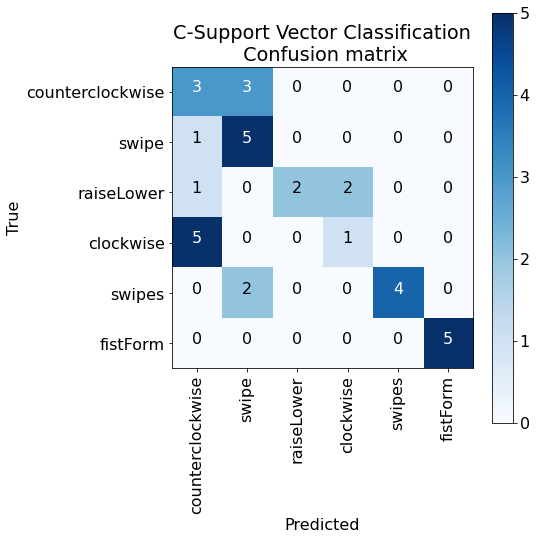

In [34]:
# compute confusion matrix
svc_matrix = confusion_matrix(test_ft_classes, svc_pred)

# plot confusion matrix
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plot_confusion_matrix(svc_matrix, set(test_ft_classes), title='C-Support Vector Classification\n Confusion matrix')

## Plot Sample Gestures Readings

In [5]:
# read_csv parameters
csv_params = "delim_whitespace=False, header=[0, 1], index_col=0"

# gestures data
gestures = []

# fist formation gesture
handDetect = pd.read_csv('csv/tests/hand_detected_1.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([handDetect, 'Hand Detetction'])
# fist formation gesture
fistForm = pd.read_csv('csv/data/fistForm/fistForm_08.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([fistForm, 'Fist Formation'])
# clockwise motion gesture
clockwise = pd.read_csv('csv/data/clockwise/clockwise_06.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([clockwise, 'Clockwise Motion'])
# counterclockwise motion gesture
counterclockwise = pd.read_csv('csv/data/counterclockwise/counterclockwise_03.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([counterclockwise, 'Counterclockwise Motion'])
# continuous swipes motion gesture
swipe = pd.read_csv('csv/data/swipe/swipe_03.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([swipe, 'Singular Swipe'])
# singular swipe motion gesture
swipes = pd.read_csv('csv/data/swipes/swipes_03.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([swipes, 'Continuous Swipes'])
# raise and Lower hand motion
raiseLower = pd.read_csv('csv/data/raiseLower/raiseLower_01.csv', delim_whitespace=False, header=[0, 1], index_col=0)
gestures.append([raiseLower, 'Raise/Lower Hand Motion'])

# testing
gesture = fistForm

#gesture = series_to_supervised(gesture, 79)
print(gesture.shape)

(15004, 1)


In [82]:
x = [3, 7, 1, 1, -2, 5, 4, 6]
coeff = pywt.wavedec(fistForm.index, 'db2')

In [106]:
foo = np.asarray(clockwise)
foo = foo.ravel()
coeff = pywt.wavedec(foo, 'db1')

In [107]:
print(len(coeff))

14


In [2190]:
# # rolling mean of gesture, reduce noise
# rollingMean_train = gesture.rolling(window = 100).mean()
# rollingMean_train = rollingMean_train.dropna().drop_duplicates()

# # define training data for gesture based on the rolling mean
# y_train = np.array(rollingMean_train.values).astype(np.double)[:,0]
# x_train = np.transpose(np.array(rollingMean_train.values))[..., np.newaxis]
# x_train = np.expand_dims(x_train, axis=0)

# # y_train = np.expand_dims(y_train, axis=-1)
# # print(y_train.shape)

# print(y_train.shape)
# print(x_train.shape)

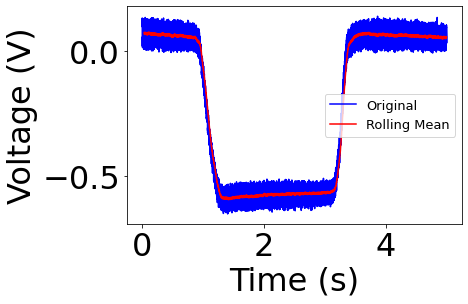

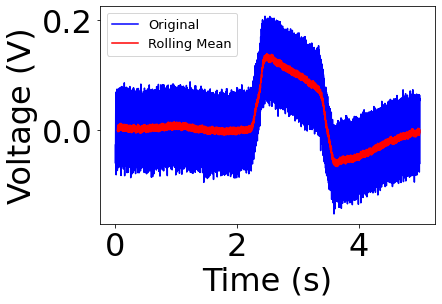

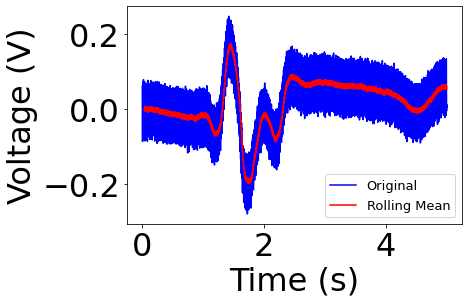

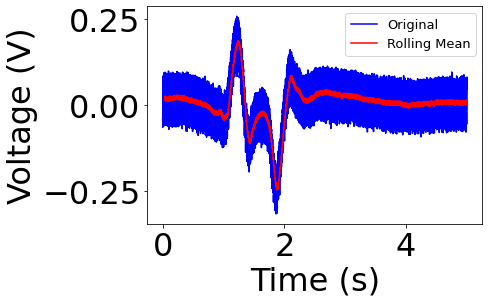

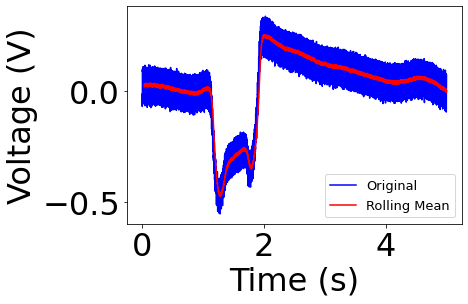

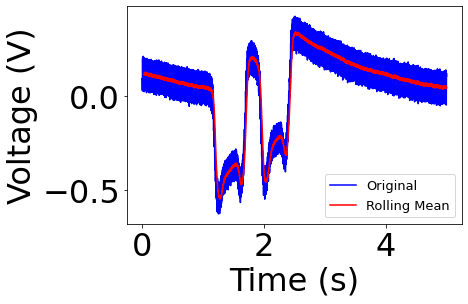

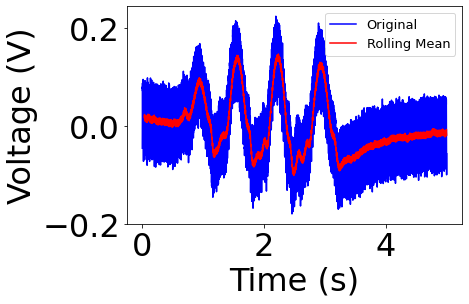

In [6]:
plt.rcParams.update({'font.size': 32})

for gesture in gestures:
    gestureDF, title = gesture
    #gestureDF.columns = gestureDF.columns.droplevel(1)
    plotTitle = title

    rollingMean = gestureDF.rolling(window = 100).mean()
    rollingMean = rollingMean.dropna()
    #rollingStd = gestureDF.rolling(window = 12).std()
    plt.plot(gestureDF, color = 'blue', label = 'Original')
    plt.plot(rollingMean, color = 'red', label = 'Rolling Mean')
    #plt.plot(rollingStd, color = 'black', label = 'Rolling STD')
    plt.legend(loc = 'best', prop={'size': 13})
    #plt.title(plotTitle)
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    #minR = round(gestureDF.min().to_numpy()[0], 1)
    #maxR = round(gestureDF.max().to_numpy()[0], 1)
    #plt.yticks(np.arange(minR, maxR, step=0.3)) 
    plt.show()

## Other stuff

In [23]:
# tests

# inp =  Input(shape=(5, 1))
# conv = Convolution1D(filters=2, kernel_size=2)(inp)
# pool = MaxPool1D(pool_size=2)(conv)
# flat = Flatten()(pool)
# dense = Dense(1)(flat)
# model = models.Model(inp, dense)
# model.compile(loss='mse', optimizer='adam')

# #print(model.summary())

# # get some data
# X = np.expand_dims(np.random.randn(10, 5), axis=2)
# y = np.random.randn(10, 1)

# print(X.shape)
# print(y.shape)

# # fit model
# model.fit(X, y)

In [2161]:
# plot the data

#fistForm.shape
#fistForm.head(3)
gestures[:5]

#handDetect['Channel A'].plot(linewidth=1);
#fistForm['Channel A'].plot(linewidth=1);
#clockwise['Channel A'].plot(linewidth=1);

[[('Channel A', '(V)')],
 [('Channel A', '(V)')],
 [('Channel A', '(V)')],
 [('Channel A', '(V)')],
 [('Channel A', '(V)')]]

# tsfresh Tests

In [ ]:
# extract features
fistForm.reset_index(inplace=True)
fistForm_features = tsfresh.extract_features(fistForm, column_id='index', n_jobs=4)

#fistForm_features = tsfresh.extract_features(fistForm)

#clockwise_features = tsfresh.extract_features(clockwise)

#counterclockwise_features = tsfresh.extract_features(counterclockwise)

#swipes_features = tsfresh.extract_features(swipes)

#swipe_features = tsfresh.extract_features(swipe)

#raiseLower_features = tsfresh.extract_features(raiseLower)

In [ ]:
from tsfresh.utilities.dataframe_functions import impute

impute(handDetect_features)

In [ ]:
#handDetect_features.head()
#handDetect.resample('3T').sum()
#handDetect.describe()

In [19]:
for gesture in gestures:
    gestureDF, title = gesture
    print(round(gestureDF.max().to_numpy()[0], 1))

0.1
-0.1
-1.1
0.1
0.1
-0.9
-0.2


In [ ]:
# tests

# import mass_ts as mts

# ts = handDetect3.to_numpy()
# q = handDetect.to_numpy()

# print(handDetect3[:,0])

# # mass
# distances = mts.mass(ts[:,0], q[:,0])

# # mass2
# distances = mts.mass2(ts[:,0], q[:,0])

# # mass3
# #distances = mts.mass3(ts[:,0], q[:,0], 256)

# # mass2_batch
# # start a multi-threaded batch job with all cpu cores and give me the top 5 matches.
# # note that batch_size partitions your time series into a subsequence similarity search.
# # even for large time series in single threaded mode, this is much more memory efficient than
# # MASS2 on its own.
# batch_size = 10000
# top_matches = 5
# n_jobs = 3
# indices, distances = mts.mass2_batch(ts[:,0], q[:,0], batch_size, 
#     top_matches=top_matches, n_jobs=n_jobs)

# # find minimum distance
# min_idx = np.argmin(distances)

# # find top 4 motif starting indices
# k = 4
# exclusion_zone = 25
# top_motifs = mts.top_k_motifs(distances, k, exclusion_zone)

# # find top 4 discord starting indices
# k = 4
# exclusion_zone = 25
# top_discords = mts.top_k_discords(distances, k, exclusion_zone)

# Wavelet analysis

In [2200]:
import pywt
x = fistForm.values
# Discrete Wavelet Transform
#cA, cD = pywt.dwt(x, 'db2')
#x2 = pywt.idwt(cA, cD, 'db2')
fistForm.describe()

Time,Channel A
(s),(V)
count,15004.000000
mean,0.014152
std,0.069606
min,-0.151738
25%,-0.044008
50%,0.013428
75%,0.057558
max,0.206610


In [2145]:
clockwise.describe()

Time,Channel A
(s),(V)
count,15004.000000
mean,0.015031
std,0.079426
min,-0.280587
25%,-0.034425
50%,0.018250
75%,0.069887
max,0.247261


In [2147]:
swipes.describe()

Time,Channel A
(s),(V)
count,15004.000000
mean,0.035194
std,0.218161
min,-0.627460
25%,-0.007889
50%,0.092776
75%,0.171209
max,0.423109


In [16]:
# for mode_name in ['zero', 'constant', 'symmetric', 'reflect', 'periodic', 'smooth', 'periodization']:
#     mode = getattr(pywt.Modes, mode_name)
#     cA, cD = pywt.dwt(x, 'db2', mode)
#     print("Mode: %d (%s)" % (mode, mode_name))

Mode: 0 (zero)
Mode: 2 (constant)
Mode: 1 (symmetric)
Mode: 6 (reflect)
Mode: 4 (periodic)
Mode: 3 (smooth)
Mode: 5 (periodization)


In [13]:
wp = pywt.WaveletPacket2D(data=x, wavelet='db1')

In [14]:
wp.data

array([[-0.4464858],
       [-0.4400769],
       [-0.4477065],
       ...,
       [-0.3476058],
       [-0.3524888],
       [-0.3497421]])

In [17]:
wp.data.shape

(15004, 1)

In [ ]:
wp['a'].data

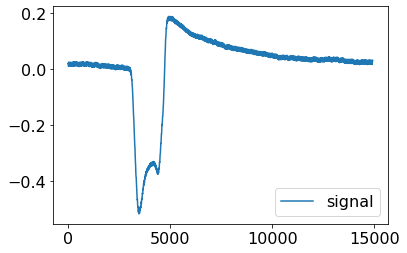

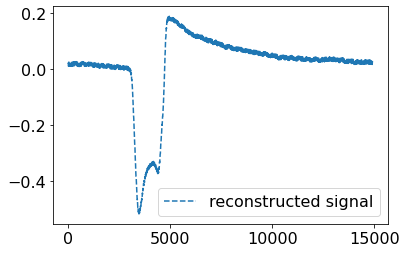

In [1757]:
(cA1, cD1) = pywt.dwt(train_data[:, 0, :, 0][2], 'db1')
reconstructed_signal = pywt.idwt(cA1, cD1, 'db1')
 
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
plt.figure()
plt.plot(train_data[:, 0, :, 0][2], label='signal')
plt.legend(loc='lower right')
plt.figure()
plt.plot(reconstructed_signal, label='reconstructed signal', linestyle='--')
plt.legend(loc='lower right')
plt.show()

In [837]:
train_lowpass_data = apply_lowpassfilter(train_data, train_batch_size)
print(lowpass_data.shape)

test_lowpass_data = apply_lowpassfilter(test_data, test_batch_size)
print(test_lowpass_data.shape)

(116, 14906)
(44, 14906)


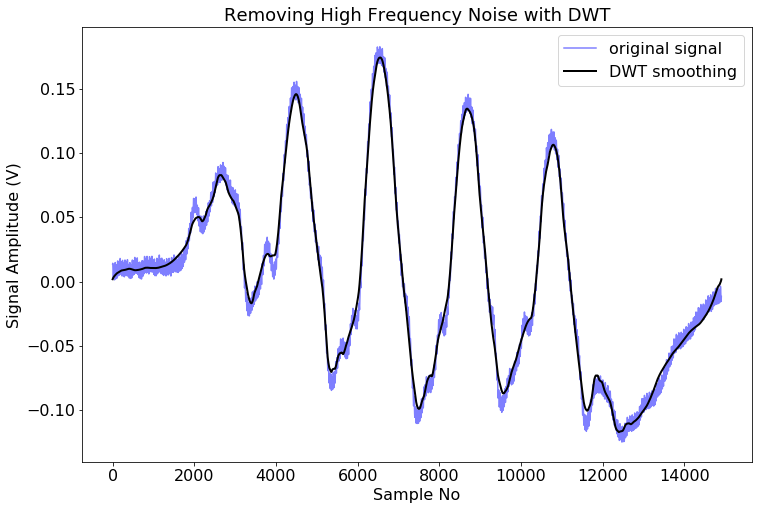

In [653]:
signal = train_data[10, 0, :, 0]
rec = train_lowpass_data[10, :]

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(signal, color="b", alpha=0.5, label='original signal')
ax.plot(rec, 'k', label='DWT smoothing', linewidth=2)
ax.legend()
ax.set_title('Removing High Frequency Noise with DWT', fontsize=18)
ax.set_ylabel('Signal Amplitude (V)', fontsize=16)
ax.set_xlabel('Sample No', fontsize=16)
plt.show()

13.214366912841797 seconds


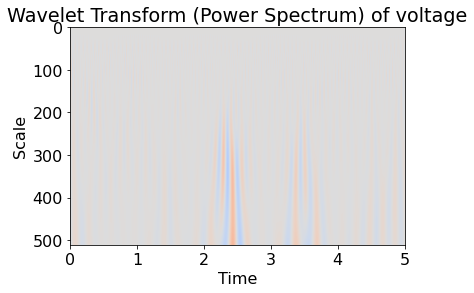

In [1365]:
import time
start_time = time.time()

def plot_cwt_coeffs_per_label(X, sample, scales, wavelet):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    coeffs, freqs = pywt.cwt(X.values.squeeze(), scales, wavelet = wavelet)
    
    # create scalogram
    ax.imshow(coeffs, cmap = 'coolwarm', aspect = 'auto', extent=[0,5,scales.shape[0],0])
    ax.set_title("Wavelet Transform (Power Spectrum) of voltage")
    ax.set_ylabel('Scale')
    ax.set_xlabel('Time')

sample = 0
scales = np.arange(1, 512)
# mother wavelet
wavelet = 'morl'

plot_cwt_coeffs_per_label(fistForm, sample, scales, wavelet)

print("%s seconds" % (time.time() - start_time))